In [4]:
import numpy as np
'''import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, concatenate, Input, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model'''
import csv, os, sys, time, errno, math, random, pickle
from PIL import Image
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from skimage import data, io, filters, transform
import word2vec, jieba
from adjustText import adjust_text
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as mfm

## PCA of colored faces

#### get eigenfaces

In [2]:
all_aberdeen_images = []

def file_num(x):
    return(int(x.split('.')[0]))

for filename in sorted(os.listdir('data/Aberdeen'), key = file_num):
    all_aberdeen_images.append(io.imread('data/Aberdeen/{}'.format(filename))) # (600, 600, 3)

In [3]:
all_aberdeen_images = np.array(all_aberdeen_images) # (415, 600, 600, 3)
ave_face = all_aberdeen_images.mean(axis=0)
all_aberdeen_images_centered = all_aberdeen_images - ave_face

In [4]:
Image.fromarray(ave_face.astype(np.uint8)).show()
Image.fromarray(ave_face.astype(np.uint8)).save('ave_face.png')

In [4]:
downsize = 100
all_aberdeen_images_centered_reshaped = []
for i in range(all_aberdeen_images_centered.shape[0]):
    all_aberdeen_images_centered_reshaped.append(transform.resize(all_aberdeen_images_centered[i],
                                                                  (downsize,downsize,3)))
all_aberdeen_images_centered_reshaped = np.array(all_aberdeen_images_centered_reshaped)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
U, s, V = np.linalg.svd(all_aberdeen_images_centered_reshaped.reshape(415,downsize*downsize*3).T,
                        full_matrices=False)

In [32]:
U.shape

(30000, 415)

In [41]:
for i in range(4):
    print(s[i] / sum(s))

0.0417806958321
0.0298867058434
0.0243999440123
0.0224443569117


In [6]:
top_4_eigenfaces_vector = U[:,0:4].copy().T

In [7]:
top_4_eigenfaces_vector.shape

(4, 30000)

In [8]:
top_4_eigenfaces_img = top_4_eigenfaces_vector.reshape(4,downsize,downsize,3)

In [9]:
ave_face_resized = transform.resize(ave_face, (downsize,downsize,3))

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [58]:
for i in range(4):
    eigenface = top_4_eigenfaces_img[i]
    eigenface_configured = eigenface - np.min(eigenface)
    eigenface_configured /= np.max(eigenface_configured)
    eigenface_configured *= 255
    result = Image.fromarray(eigenface_configured.astype(np.uint8))
    result.save('eigenface_yo_{}.png'.format(i))

In [15]:
eigenface = U[:,9].reshape(downsize,downsize,3)
eigenface_configured = eigenface - np.min(eigenface)
eigenface_configured /= np.max(eigenface_configured)
eigenface_configured *= 255
result = Image.fromarray(eigenface_configured.astype(np.uint8))
result.show()

#### reconstruct faces using top 4 eigenfaces

In [10]:
for i in [0,3,5,6]:
    face_id = i
    original_face_centered = all_aberdeen_images_centered_reshaped[face_id]
    reconstructed_face = np.zeros((downsize,downsize,3))
    for a in range(4):
        eigenface = top_4_eigenfaces_img[a]
        # eigenface = U[:,i].reshape((downsize, downsize, 3))
        coeff = np.sum(np.multiply(original_face_centered, eigenface))
        print(coeff)
        reconstructed_face += coeff * eigenface # no need to normalize, eigenfaces already orthonormal
    # Image.fromarray(reconstructed_face.astype(np.uint8)).show()
    reconstructed_face += ave_face_resized
    reconstructed_face -= np.min(reconstructed_face)
    reconstructed_face /= np.max(reconstructed_face)
    reconstructed_face *= 255

    io.imsave('reconstructed_zo{}.jpg'.format(face_id), reconstructed_face.astype(np.uint8))

-4289.00270959
-2823.0597231
1108.42894737
-3627.40384825
971.143281903
3728.43828267
928.699433312
-2031.410061
-12134.4199169
-4361.95092811
-3104.86663115
512.031597848
-816.21961053
-603.466068091
573.993244894
-165.884921899


## Visualization of Chinese word embedding

#### get word segments and train word vectors

In [2]:
jieba.load_userdict('data/dict.txt.big.txt')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/7x/cbgl753s3z37q61s9kcbgvt80000gn/T/jieba.cache
Loading model cost 0.756 seconds.
Prefix dict has been built succesfully.


In [3]:
a = time.time()
with open('data/all_sents.txt', 'r') as all_sents_file:
    with open('data/all_phrases.txt', 'w') as all_phrases_file:
        for line in all_sents_file:
            seg_list = jieba.cut(line)
            all_phrases_file.write(" ".join(seg_list))  # 精确模式
print('completed after', time.time()-a, 'seconds')

completed after 37.932173013687134 secondsa


In [8]:
word2vec.word2vec('data/all_phrases.txt', 'data/text8.bin',
                  size=100, min_count=5000, verbose=True)

Starting training using file data/all_phrases.txt
Vocab size: 93
Words in train file: 2387875
Alpha: 0.001091  Progress: 95.72%  Words/thread/sec: 750.39k  

#### load word vectors

In [16]:
model = word2vec.load('data/text8.bin')

In [18]:
indexes, metrics = model.cosine('媽媽')
print(metrics)
print(model.vocab[indexes])

[ 0.43857058  0.39435364  0.34204726  0.23638034  0.23265084  0.19100806
  0.18895396  0.17965506  0.15499582  0.14995634]
['她' '我' '有志' '好好' '一定' '想' '真的' '妳' '今天' '幫']


In [19]:
print(model.vocab[5])
print(model.vectors[5])
print(model['了'])

了
[ -1.10401995e-01  -1.74544267e-02  -1.38576537e-01   5.65478690e-02
   1.17756739e-01  -9.09614190e-02  -1.41094834e-01   8.97624567e-02
  -6.27433807e-02  -1.48224056e-01   7.44145811e-02   4.82550450e-02
  -1.68006361e-01  -2.21173838e-01  -2.48490013e-02   2.50866301e-02
   5.64601049e-02  -2.18355097e-02  -1.86608881e-01   1.26716495e-02
  -3.75467315e-02  -4.90337983e-02  -1.91468522e-02   2.09693927e-02
   2.67825630e-02   7.21294209e-02  -2.20461309e-01   3.66427898e-02
  -9.53434557e-02   5.37679647e-04   1.45748705e-02   8.38694721e-02
  -2.01750025e-02  -1.07205026e-01  -2.97804107e-03   6.63057044e-02
   4.83534448e-02   8.66900384e-02  -1.86592259e-03  -2.53938138e-01
   1.95609495e-01  -4.52204794e-02  -3.72789763e-02   1.94689274e-01
  -1.82192534e-01   7.77159482e-02  -5.64120710e-02  -1.99174639e-02
  -5.44528943e-03  -1.56248659e-01   1.31924113e-03  -4.46569435e-02
   2.15115268e-02   6.11699112e-02   1.78818945e-02   4.78633121e-02
  -1.44820698e-02  -1.07517429e-

In [17]:
a = time.time()
wordvec_tsne = TSNE(n_components=2).fit_transform(model.vectors) # takes about 2 minutes
print('finished after', time.time()-a,'seconds')

finished after 0.9628100395202637 seconds


In [18]:
wordvec_tsne.shape

(93, 2)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['STHeiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


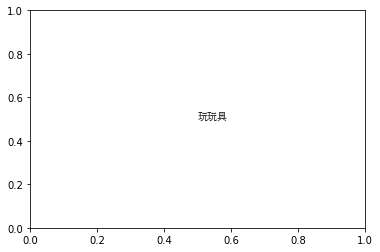

In [15]:
font_path = "/System/Library/Assets/com_apple_MobileAsset_Font3/85c1c77a7c430b02315e74dec55f9a7f004f556b.asset/AssetData/华文细黑.ttf"
prop = mfm.FontProperties(fname=font_path)
plt.text(0.5, 0.5, s='玩玩具', fontproperties=prop)
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['STHeiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


finished after 8.680706977844238 seconds


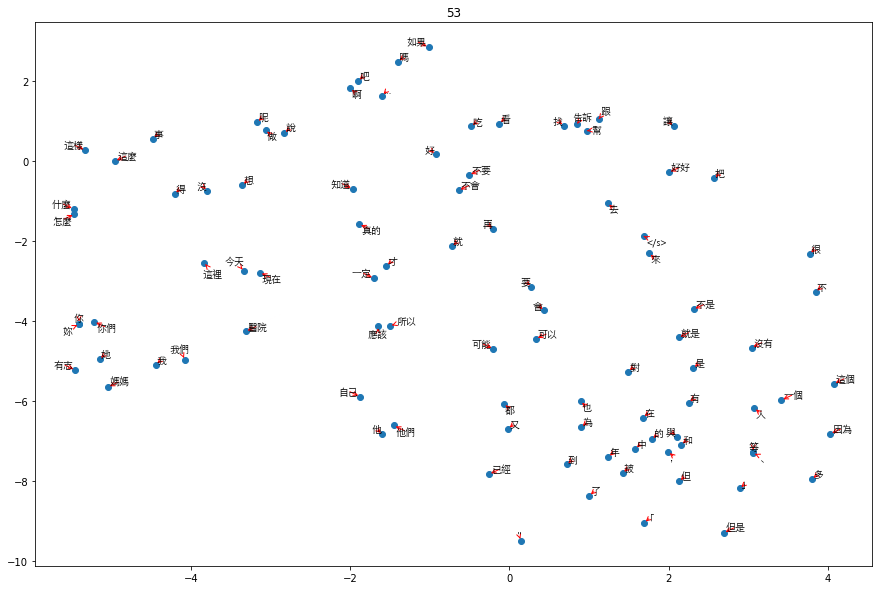

In [27]:
adjust = True
a = time.time()
plt.figure(figsize=(15, 10))
plt.scatter(x=wordvec_tsne[:,0], y=wordvec_tsne[:,1])
texts = []
for x, y, word in zip(wordvec_tsne[:,0], wordvec_tsne[:,1], model.vocab):
    texts.append(plt.text(x, y, word, fontproperties=prop))
if adjust:
    plt.title(str(adjust_text(texts, wordvec_tsne[:,0], wordvec_tsne[:,1], arrowprops=dict(arrowstyle="->", color='r'))))
plt.savefig('wordvec_visualize.png')
print('finished after', time.time()-a,'seconds')

## clustering images

#### load images

In [2]:
images = np.load('data/image.npy')

In [5]:
images.shape

(140000, 784)

In [14]:
for i in range(0,100):
    img = Image.fromarray(images[i].reshape(28,28))
    img.save('data/image_output/{}.png'.format(i))

### Dimension Reduction

#### PCA

In [7]:
a = time.time()
pca = PCA(n_components=700, whiten=True, svd_solver='arpack')
pca.fit(images)
print('completed after', time.time()-a, 'seconds') # takes around 80 seconds

completed after 82.57314467430115 seconds


In [8]:
print(pca.components_.shape)

(700, 784)


In [121]:
for i in range(len(pca.components_)):
    img = Image.fromarray((pca.components_[i]*30).astype('uint8').reshape(28,28)) # amplified pixel strength
    img.save('data/eigen_images/{}.png'.format(i))

In [14]:
old_images = False
if old_images:
    pca_images = pca.transform(images)
else:
    new_images = np.load('data/visualization.npy')
    pca_images = pca.transform(new_images)

In [29]:
# if you want to see new_images
for i in range(0,50):
    img = Image.fromarray(new_images[i].reshape(28,28))
    img.save('data/new_images/{}.png'.format(i))
    img = Image.fromarray(new_images[i+5000].reshape(28,28))
    img.save('data/new_images/{}.png'.format(i+5000))

In [15]:
pca_images.shape

(10000, 700)

In [ ]:
reconstructed_images = pca.inverse_transform(pca_images) # with n_components = 784, looks the same to me

In [124]:
Image.fromarray(reconstructed_images[6].reshape(28,28)).show()

#### NMF

In [78]:
nmf = NMF(n_components=40, init='random', random_state=0, max_iter=20).fit(images)

In [79]:
nmf.components_.shape

(40, 784)

In [66]:
for i in range(len(nmf.components_)):
    img = Image.fromarray(pca.components_[i].astype('uint8').reshape(28,28))
    img.save('data/nmf_images/{}.png'.format(i))

#### autoencoder

In [ ]:
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Clustering: K-means

In [16]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300,
                tol=0.0001, precompute_distances='auto', verbose=0,
                random_state=None, copy_x=True, n_jobs=1, algorithm='auto').fit(pca_images)

In [ ]:
len(kmeans.labels_)

In [20]:
for idx in range(4950,5050):
    print(idx, kmeans.labels_[idx])

4950 0
4951 0
4952 0
4953 0
4954 0
4955 0
4956 0
4957 0
4958 0
4959 0
4960 0
4961 0
4962 0
4963 0
4964 0
4965 0
4966 0
4967 0
4968 0
4969 0
4970 0
4971 0
4972 0
4973 0
4974 0
4975 0
4976 0
4977 0
4978 0
4979 0
4980 0
4981 0
4982 0
4983 0
4984 0
4985 0
4986 0
4987 0
4988 0
4989 0
4990 0
4991 0
4992 0
4993 0
4994 0
4995 0
4996 0
4997 0
4998 0
4999 0
5000 1
5001 1
5002 1
5003 1
5004 1
5005 1
5006 1
5007 1
5008 1
5009 1
5010 1
5011 1
5012 1
5013 1
5014 1
5015 1
5016 1
5017 1
5018 1
5019 1
5020 1
5021 1
5022 1
5023 1
5024 1
5025 1
5026 1
5027 1
5028 1
5029 1
5030 1
5031 1
5032 1
5033 1
5034 1
5035 1
5036 1
5037 1
5038 1
5039 1
5040 1
5041 1
5042 1
5043 1
5044 1
5045 1
5046 1
5047 1
5048 1
5049 1


In [22]:
a = time.time()
pca_then_tsne = TSNE(n_components=2).fit_transform(pca_images)
print('completed after', time.time()-a, 'seconds')

completed after 387.8863060474396 seconds


finished after 0.7522521018981934 seconds


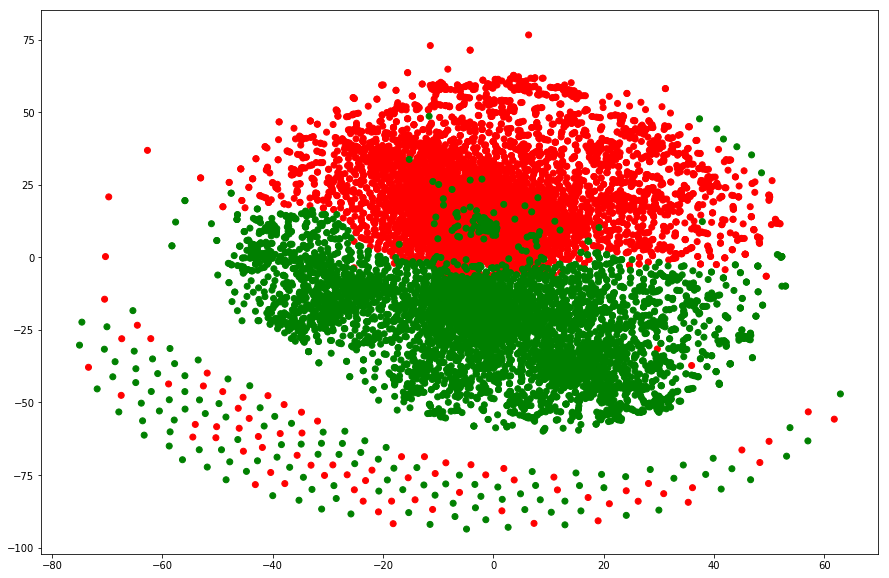

In [24]:
a = time.time()
plt.figure(figsize=(15, 10))
plt.scatter(x=pca_then_tsne[:,0], y=pca_then_tsne[:,1], color=['red' if label == 0 else 'green' for label in kmeans.labels_])
plt.savefig('img_pred.png')
print('finished after', time.time()-a,'seconds')

finished after 0.773184061050415 seconds


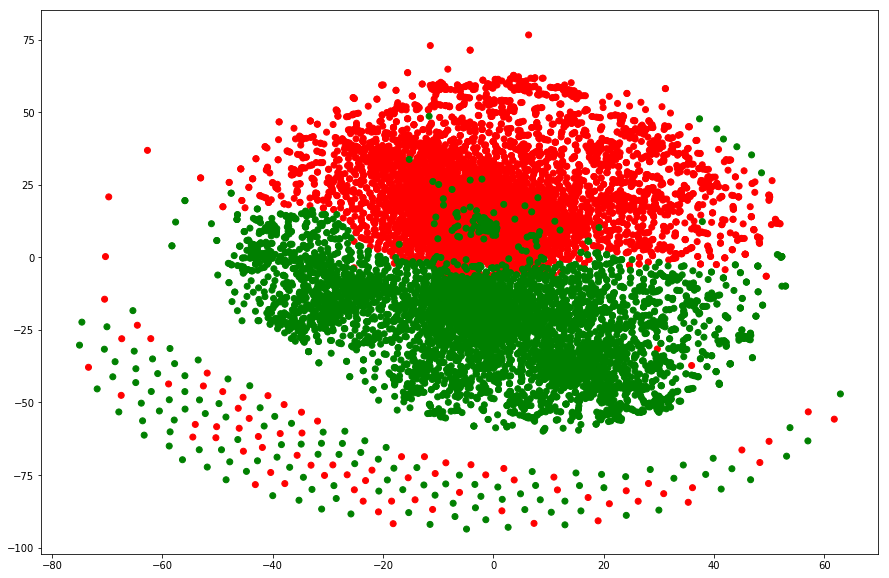

In [26]:
a = time.time()
plt.figure(figsize=(15, 10))
plt.scatter(x=pca_then_tsne[:,0], y=pca_then_tsne[:,1], color=['red' if idx<5000 else 'green' for idx in range(len(pca_then_tsne))])
plt.savefig('img_ground_truth.png')
print('finished after', time.time()-a,'seconds')

In [137]:
with open('labels.pickle', 'wb') as handle:
    pickle.dump(kmeans.labels_, handle, protocol=pickle.HIGHEST_PROTOCOL)

## rule-based

In [150]:
rule_predictions = [] # 1 for MNIST, 0 for fashionMNIST
count = 0

for idx, image in enumerate(images): # estimate 3 minutes
    if idx % 5000 == 0:
        print('finished processing', idx/len(images))
        
    pixel_count = 0
    non_black_count = 0
    near_white_count = 0
    
    for pixel in image:
        pixel_count += 1
        if pixel > 0:
            non_black_count += 1
            if pixel > 200:
                near_white_count += 1
                
    # if near_white_count / non_black_count > 0.5:
    if non_black_count / pixel_count > 0.3:
        # predictions.append(1)
        rule_predictions.append(0)
    else:
        # predictions.append(0)
        rule_predictions.append(1)
    count += 1
print('finished generating rule_predictions!')

"rule_predictions = [] # 1 for MNIST, 0 for fashionMNIST\ncount = 0\n\nfor idx, image in enumerate(images): # estimate 3 minutes\n    if idx % 5000 == 0:\n        print('finished processing', idx/len(images))\n        \n    pixel_count = 0\n    non_black_count = 0\n    near_white_count = 0\n    \n    for pixel in image:\n        pixel_count += 1\n        if pixel > 0:\n            non_black_count += 1\n            if pixel > 200:\n                near_white_count += 1\n                \n    # if near_white_count / non_black_count > 0.5:\n    if non_black_count / pixel_count > 0.3:\n        # predictions.append(1)\n        rule_predictions.append(0)\n    else:\n        # predictions.append(0)\n        rule_predictions.append(1)\n    count += 1\nprint('finished generating rule_predictions!')"

In [151]:
for i in range(100):
    print(i, rule_predictions[i])

'for i in range(100):\n    print(i, rule_predictions[i])'

## Submission

### read test file

In [9]:
x_submission = []

with open('data/test_case.csv', 'rt') as testfile:
    reader = csv.reader(testfile, delimiter=',')
    next(reader) # skip headings
    for row in reader:
        # print([int(row[1]), int(row[2])])
        x_submission.append([int(row[1]), int(row[2])])
print('finished reading file')

finished reading file


In [10]:
len(x_submission)

1980000

In [132]:
x_submission[2]

[68922, 34890]

#### PCA

In [27]:
predictions = []

for id_pair in x_submission:
    if kmeans.labels_[id_pair[0]] == kmeans.labels_[id_pair[1]]:
        predictions.append(1)
    else:
        predictions.append(0)
print(len(predictions))

1980000


#### rule-based

In [147]:
predictions = []

for id_pair in x_submission:
    if rule_predictions[id_pair[0]] == rule_predictions[id_pair[1]]:
        predictions.append(1)
    else:
        predictions.append(0)
print(len(predictions))

1980000


### write submission

In [28]:
with open('again.csv', 'wt') as outfile:
    test_writer = csv.writer(outfile)
    test_writer.writerow(['ID','Ans'])
    
    counter = 0
    for i in predictions:
        test_writer.writerow([counter, int(i)])
        counter += 1
    
print('finished writing submission!')

finished writing submission!
